### Center for Trafficking Data Analysis
I will begin by importing the necessary packages, setting my graphing style, and loading the cleaned data. 
Then, I will identify the features we seek to predict.

In [77]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import Logit

sns.set(color_codes = True)
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(10,10)})
sns.set_palette("Set3")

df = pl.read_csv('data/final_data.csv')
exploitation_strings = df['exploitation_types']
df = df.drop('exploitation_types')
target_features = ['isForcedLabour', 'isSexualExploit']

To begin the analysis, I will create a correlatoin heatmap of all of the predictive features. This will help me get a jist of trends across features.

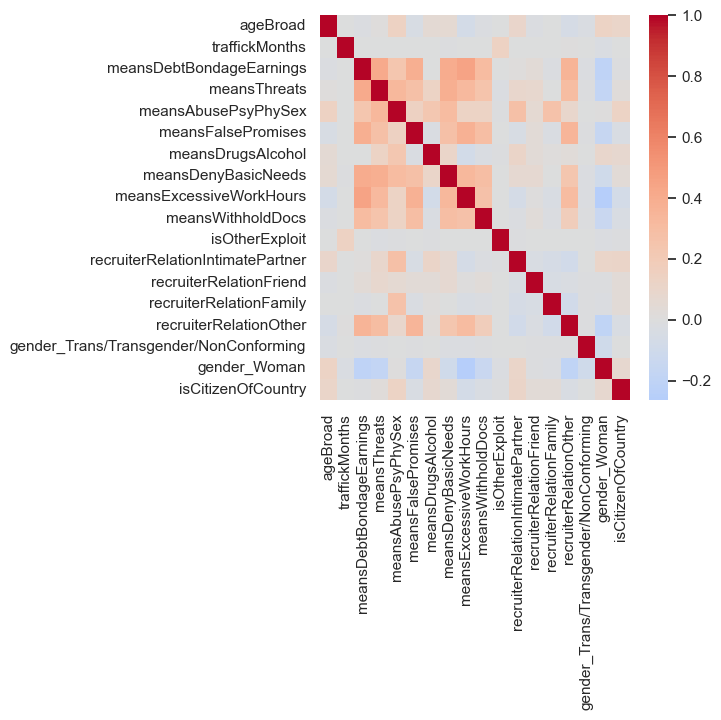

In [78]:
def plot_correlation(df, target_features):
    df = df.select(pl.exclude(target_features)) # remove target features
    fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(df.to_pandas().corr(), annot=False, cmap='coolwarm', center=0)
    plt.show()

plot_correlation(df, target_features)

Here, we see some correlatoin particularly between certain kinds of means of control like debt and documentation witholding. More interesting relationships appear, like a correlation between means of control psychological abuse and recruiter realtionship being with a family member. 

Now, I will begin preparing the regression analysis.

First, I will sepearte the target features in the data from the predictive features (X vs Ys).

Then, I will do an 80/20 split between training and testing data, followed by sperating the Ys column into the two distinct categoires to be used in their own models. 

Finally, due to the nature of the regression package I am using, an intercept must be added to our feature matrices. 
I save aside feature_names for later utility

In [79]:
Ys = df.select(target_features)
X = df.select(pl.exclude(target_features))
X_train, X_test, y_train, y_test = (
    train_test_split(X.to_pandas(), Ys.to_pandas(), test_size=0.2, random_state=42)
    )

labor_train = y_train['isForcedLabour']
sexual_train = y_train['isSexualExploit']

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
feature_names = X.columns


Next, I will choose an alpha value. This is in order to perform regularization on my coefficients. This will help address multicolinneartiy issues, and provide natural feature selection to improve the interpretaion of our results. Here, we are using Lasso regularizatoin

In [80]:
def choose_alpha(labor_train, sexual_train, X_train, X_test, y_test):
    auc_rows = []
    candidate_alphas = [0.1, 1.0]
    for a in candidate_alphas:
        print(f"\nEvaluating alpha = {a}...")
        m_labor = Logit(labor_train, X_train).fit_regularized(
            method='l1_cvxopt_cp', alpha=a, maxiter=1000, cnvrg_tol=1e-8, disp=False
        )
        m_sexual = Logit(sexual_train, X_train).fit_regularized(
            method='l1_cvxopt_cp', alpha=a, maxiter=1000, cnvrg_tol=1e-8, disp=False
        )
        auc_labor = roc_auc_score(y_test['isForcedLabour'], m_labor.predict(X_test))
        auc_sexual = roc_auc_score(y_test['isSexualExploit'], m_sexual.predict(X_test))
        auc_rows.append({
            "alpha": a,
            "AUC_forced": auc_labor,
            "AUC_sexual": auc_sexual,
            "AUC_mean": np.mean([auc_labor, auc_sexual]),
        })
    validation_df = pd.DataFrame(auc_rows).sort_values("AUC_mean", ascending=False)
    chosen_alpha = np.max(validation_df.iloc[0]["alpha"])
    print(f"Chosen alpha across models: {chosen_alpha}")
    return chosen_alpha

alpha = choose_alpha(labor_train, sexual_train, X_train, X_test, y_test)


Evaluating alpha = 0.1...

Evaluating alpha = 1.0...
Chosen alpha across models: 0.1


Next, we fit the models:

In [81]:
model_labor = Logit(labor_train, X_train).fit_regularized(
    method='l1_cvxopt_cp', alpha=alpha, disp=False)

model_sexual = Logit(sexual_train, X_train).fit_regularized(
    method='l1_cvxopt_cp', alpha=alpha, disp=False)

Before investigating our model coefficients, lets see how well they are fitting with AUC-ROC curves. This identifies the rate of true to false positives.

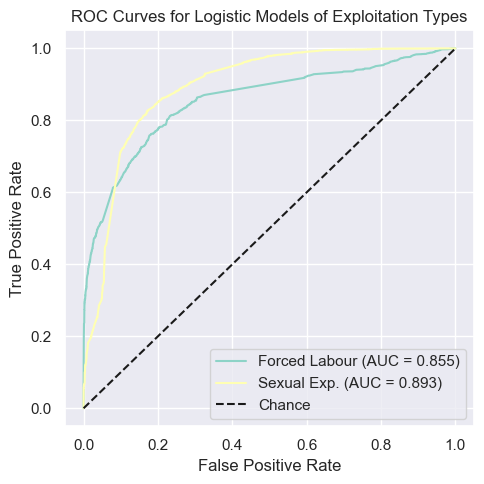

In [82]:
def plot_roc(models, X, y_trues, title=None):
    """
    Plot ROC curves for multiple fitted Logit models.
    models  : list of fitted models (e.g. [model_labor, model_sexual])
    X       : feature matrix to evaluate on (e.g. X_test, with constant)
    y_trues : list of true label arrays (same order as models)
    labels  : list of curve labels (for legend)
    """
    plt.figure(figsize=(5, 5))
    for model, y_true, label in zip(models, y_trues, ['Forced Labour', 'Sexual Exp.', 'Other Exp.']):
        y_score = model.predict(X)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_val = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_val:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title or 'ROC curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
plot_roc(
    models=[model_labor, model_sexual],
    X=X_test,
    y_trues=[y_test['isForcedLabour'], y_test['isSexualExploit']],
    title='ROC Curves for Logistic Models of Exploitation Types'
)

The L1‑regularized logistic models showed good discrimination for both outcomes, with AUC‑ROC of 0.86 for forced labour and 0.89 for sexual exploitation, indicating that the models can reliably distinguish exploited from non‑exploited cases across a range of decision thresholds.

Now, we can investigate the model coefficients. This begins by creating the odds ratios, which means taking $$OR = e^{\text{coef}} $$


Next, sexual exploitation:

Now, to investigate further how the odds likelihoods change across exploitation types, I will create a forest plot of the odds ratios. 

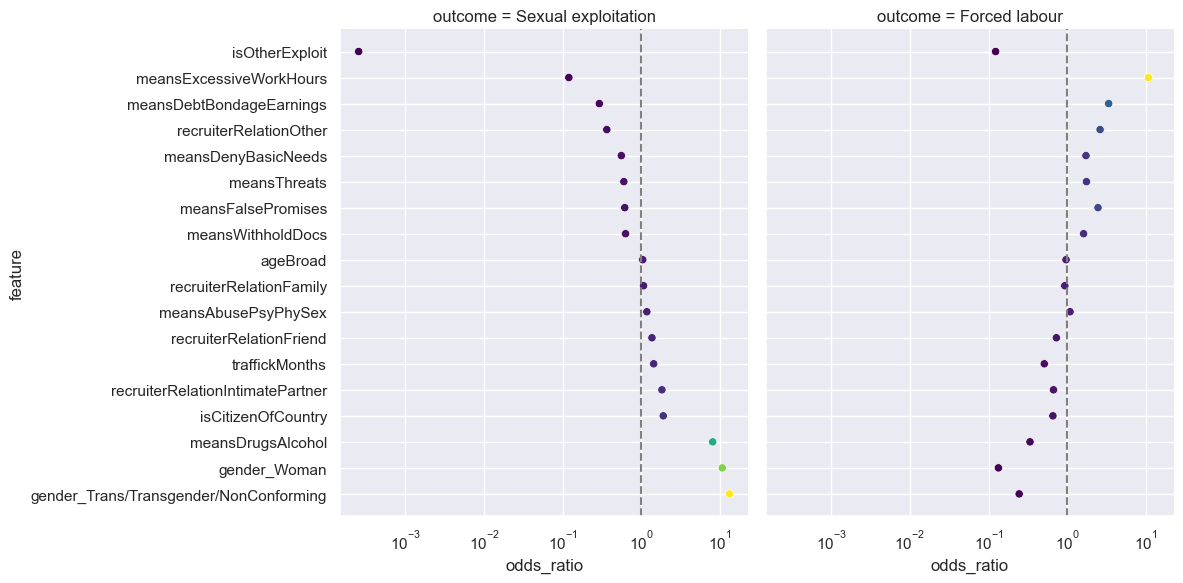

<Figure size 1000x1000 with 0 Axes>

In [86]:
odds_labor['outcome'] = 'Forced labour'
odds_sexual['outcome'] = 'Sexual exploitation'
odds_all = pd.concat([odds_labor, odds_sexual])

def forest_plot(odds_all):
    g = sns.FacetGrid(
        odds_all.sort_values('odds_ratio'),
        col='outcome',          # was row='outcome'
        sharex=True, sharey=True,
        height=6,
        )
    g.map_dataframe(
        sns.scatterplot,
        x='odds_ratio', y='feature',
        hue='odds_ratio', palette='viridis', legend=True
    )

    for ax in g.axes.flatten():
        ax.axvline(1, ls='--', c='grey')
        ax.set_xscale('log')

    plt.tight_layout()
    plt.show()
    g.fig.set_size_inches(10, 10)  # width, height in
    plt.show()
    plt.savefig('forest_plot.svg')

forest_plot(odds_all)